In [ ]:
!pip install catboost
!pip install shap

In [ ]:
import warnings

import random

import numpy as np
import pandas as pd
import scipy.stats as sps

import catboost
import catboost.datasets
import shap
import sklearn
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", mpl.MatplotlibDeprecationWarning)
warnings.simplefilter("ignore", UserWarning)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ content/housing_price/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ content/housing_price/test.csv')

In [ ]:
test_id = test['Id']

In [ ]:
train = train[['OverallQual', 'TotalBsmtSF', 'GrLivArea', '1stFlrSF', 'GarageCars', 'GarageArea', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'SalePrice']]
test = test[['OverallQual', 'TotalBsmtSF', 'GrLivArea', '1stFlrSF', 'GarageCars', 'GarageArea', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea']]

In [ ]:
train.isna().mean()

OverallQual     0.000000
TotalBsmtSF     0.000000
GrLivArea       0.000000
1stFlrSF        0.000000
GarageCars      0.000000
GarageArea      0.000000
TotRmsAbvGrd    0.000000
FullBath        0.000000
YearBuilt       0.000000
GarageYrBlt     0.055479
YearRemodAdd    0.000000
Fireplaces      0.000000
MasVnrArea      0.005479
SalePrice       0.000000
dtype: float64

In [ ]:
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mean())

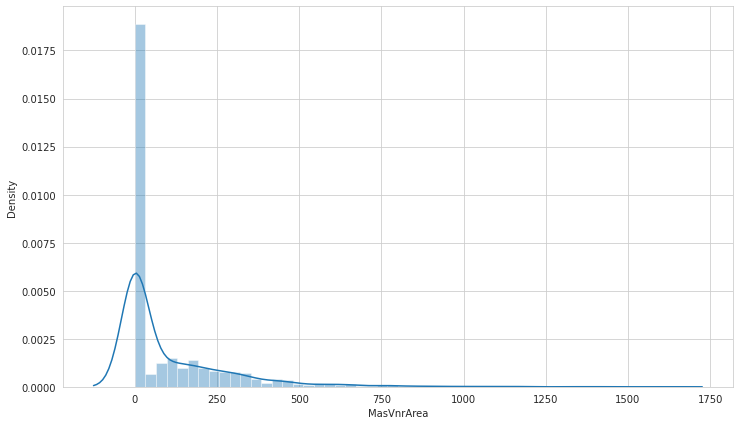

In [ ]:
with sns.plotting_context(font_scale=1.5), sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 7))
    sns.distplot(train['MasVnrArea']);

In [ ]:
train['MasVnrArea'] = np.log1p(train['MasVnrArea'])

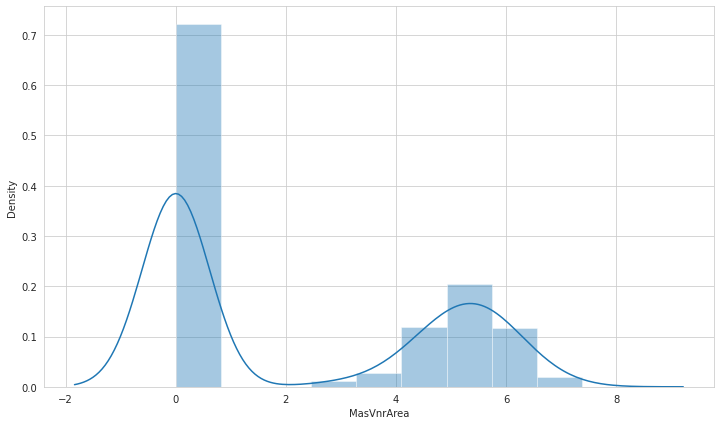

In [ ]:
with sns.plotting_context(font_scale=1.5), sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 7))
    sns.distplot(train['MasVnrArea']);

In [ ]:
train['MasVnrArea'].value_counts()

0.000000    861
5.198497      8
4.691348      8
4.290459      8
4.650958      8
           ... 
5.056246      1
5.099866      1
3.465736      1
5.937536      1
6.826545      1
Name: MasVnrArea, Length: 328, dtype: int64

In [ ]:
train['MasVnrArea'] = [0 if item == 0 else 1 for item in train['MasVnrArea']]

In [ ]:
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mode()[0])
train['GarageYrBlt'] = train['GarageYrBlt'].astype(int)

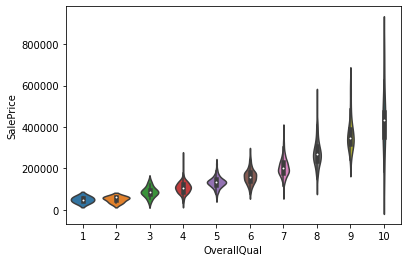

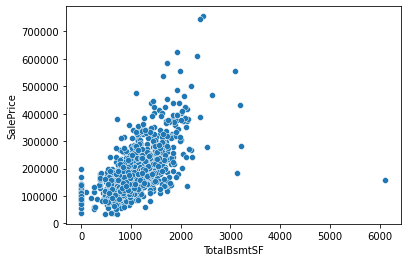

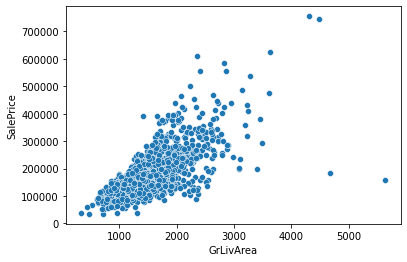

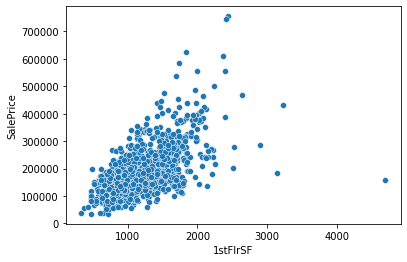

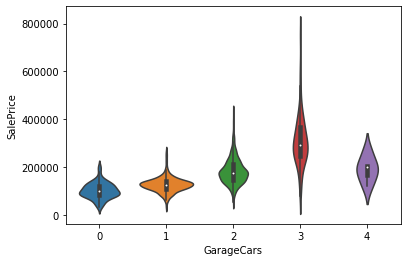

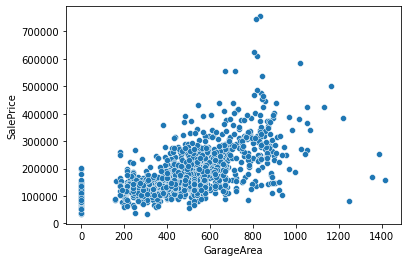

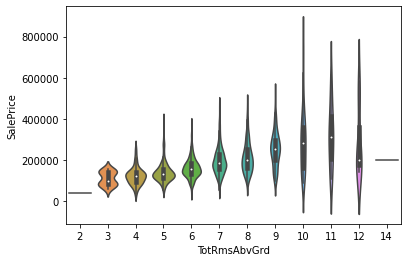

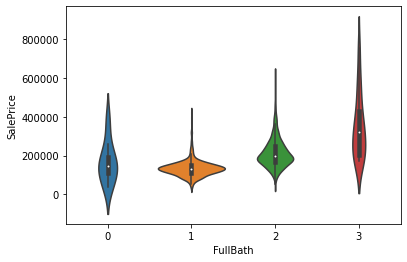

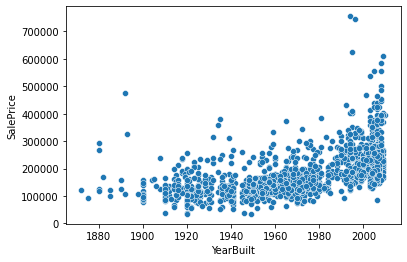

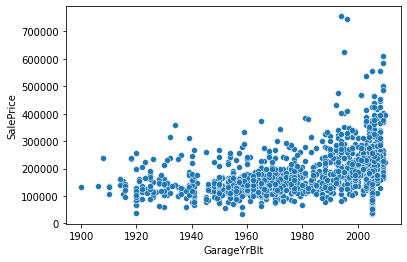

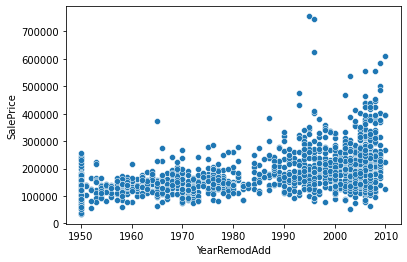

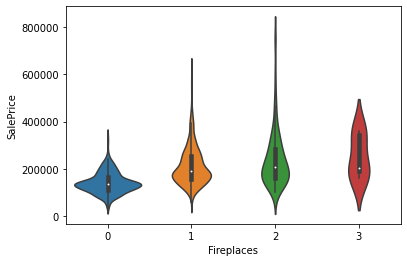

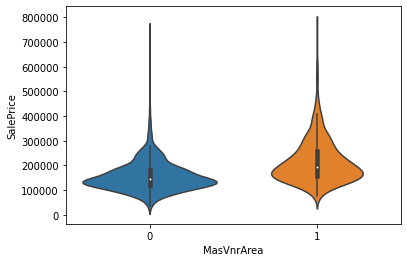

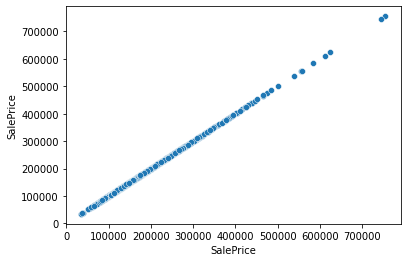

In [ ]:
for item in train.columns:
  if len(train[item].unique()) < 20:
        sns.violinplot(x=train[item],y=train['SalePrice'])
        plt.show()
  else:
        sns.scatterplot(x=train[item],y=train['SalePrice'])
        plt.show()

In [ ]:
train[['YearBuilt', 'YearRemodAdd']]

,YearBuilt,YearRemodAdd
0,2003,2003
1,1976,1976
2,2001,2002
3,1915,1970
4,2000,2000
...,...,...
1455,1999,2000
1456,1978,1988
1457,1941,2006
1458,1950,1996


In [ ]:
train['Is_remod'] = np.nan
for i in range(len(train)):
  if train['YearBuilt'][i] == train['YearRemodAdd'][i]:
    train['Is_remod'][i] = 0
  else:
    train['Is_remod'][i] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train.drop(columns = 'YearRemodAdd', inplace=True)

In [ ]:
train.drop(columns='GarageYrBlt', inplace=True)

In [ ]:
train = train.loc[(train['TotalBsmtSF'] < 4000) & (train['GrLivArea'] < 4000) & (train['1stFlrSF'] < 4000)]

In [ ]:
x = train.drop(columns='SalePrice')
y = train['SalePrice']

In [ ]:
random.seed(2021)
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    x,
    y,
    test_size=0.2,
)

In [ ]:
lr = sklearn.linear_model.LinearRegression().fit(train_X, train_y)

In [ ]:
lr.score(val_X, val_y)

0.7844441296035707

In [ ]:
rf = sklearn.ensemble.RandomForestRegressor().fit(train_X, train_y)

In [ ]:
rf.score(val_X, val_y)

0.8434894496065027

In [ ]:
features = pd.DataFrame()
features['Name'] = x.columns
features['Important'] = rf.feature_importances_
print(features)

            Name  Important
0    OverallQual   0.570182
1    TotalBsmtSF   0.076300
2      GrLivArea   0.161607
3       1stFlrSF   0.047106
4     GarageCars   0.024705
5     GarageArea   0.046030
6   TotRmsAbvGrd   0.014619
7       FullBath   0.010356
8      YearBuilt   0.035410
9     Fireplaces   0.009182
10    MasVnrArea   0.001856
11      Is_remod   0.002649


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ content/housing_price/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ content/housing_price/test.csv')

In [ ]:
test_id = test['Id']

In [ ]:
train = train[['OverallQual', 'TotalBsmtSF', 'GrLivArea', '1stFlrSF', 'GarageCars', 'GarageArea', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt',  'Fireplaces', 'Neighborhood', 'LotArea', 'SalePrice']]
test = test[['OverallQual', 'TotalBsmtSF', 'GrLivArea', '1stFlrSF', 'GarageCars', 'GarageArea', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt',  'Fireplaces', 'Neighborhood', 'LotArea']]

In [ ]:
train.isna().mean()

OverallQual     0.0
TotalBsmtSF     0.0
GrLivArea       0.0
1stFlrSF        0.0
GarageCars      0.0
GarageArea      0.0
TotRmsAbvGrd    0.0
FullBath        0.0
YearBuilt       0.0
Fireplaces      0.0
Neighborhood    0.0
LotArea         0.0
SalePrice       0.0
dtype: float64

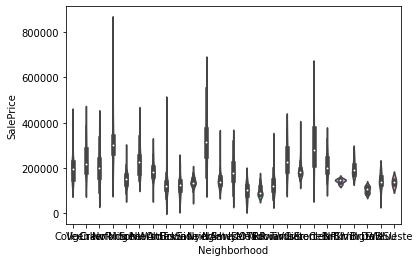

In [ ]:
sns.violinplot(x=train['Neighborhood'],y=train['SalePrice'])
plt.show()

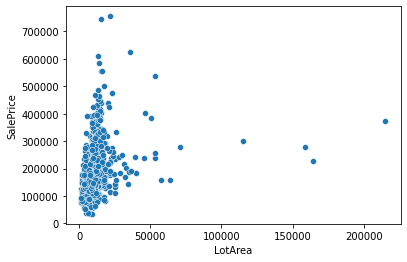

In [ ]:
sns.scatterplot(x=train['LotArea'],y=train['SalePrice'])
plt.show()

In [ ]:
train.head()

,OverallQual,TotalBsmtSF,GrLivArea,1stFlrSF,GarageCars,GarageArea,TotRmsAbvGrd,FullBath,YearBuilt,Fireplaces,Neighborhood,LotArea,SalePrice
0,7,856,1710,856,2,548,8,2,2003,0,CollgCr,8450,208500
1,6,1262,1262,1262,2,460,6,2,1976,1,Veenker,9600,181500
2,7,920,1786,920,2,608,6,2,2001,1,CollgCr,11250,223500
3,7,756,1717,961,3,642,7,1,1915,1,Crawfor,9550,140000
4,8,1145,2198,1145,3,836,9,2,2000,1,NoRidge,14260,250000


In [ ]:
le = sklearn.preprocessing.LabelEncoder()
train['Neighborhood'] = train['Neighborhood'].astype(str)
le.fit(train['Neighborhood'])
train['Neighborhood'] = le.transform(train['Neighborhood'])

In [ ]:
x = train.drop(columns='SalePrice')
y, lam = sps.boxcox(train['SalePrice'])

In [ ]:
random.seed(2021)
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    x,
    y,
    test_size=0.2,
)

In [ ]:
lr_1 = sklearn.linear_model.LinearRegression().fit(train_X, train_y)

In [ ]:
lr_1.score(val_X, val_y)

0.7260762307894897

In [ ]:
rf_1 = sklearn.ensemble.RandomForestRegressor().fit(train_X, train_y)

In [ ]:
rf_1.score(val_X, val_y)

0.8387783281964221

In [ ]:
rf_final = sklearn.ensemble.RandomForestRegressor().fit(x, y)

In [ ]:
test.isna().mean()

OverallQual     0.000000
TotalBsmtSF     0.000685
GrLivArea       0.000000
1stFlrSF        0.000000
GarageCars      0.000685
GarageArea      0.000685
TotRmsAbvGrd    0.000000
FullBath        0.000000
YearBuilt       0.000000
Fireplaces      0.000000
Neighborhood    0.000000
LotArea         0.000000
dtype: float64

In [ ]:
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean())
test['GarageArea'] = test['GarageArea'].fillna(test['GarageArea'].mean())
test['GarageCars'] = test['GarageCars'].fillna(test['GarageCars'].mode()[0])

In [ ]:
le = sklearn.preprocessing.LabelEncoder()
test['Neighborhood'] = test['Neighborhood'].astype(str)
le.fit(test['Neighborhood'])
test['Neighborhood'] = le.transform(test['Neighborhood'])

In [ ]:
from scipy.special import inv_boxcox
pred = rf_final.predict(test)
pred = inv_boxcox(pred, lam)

In [ ]:
result = pd.DataFrame()
result['Id'] = test_id
result['SalePrice'] = pred

In [ ]:
result.to_csv('submit_final.csv', encoding='utf-8', index=False)

0.15859

In [ ]:
features = pd.DataFrame()
features['Name'] = x.columns
features['Important'] = rf_final.feature_importances_
print(features)

            Name  Important
0    OverallQual   0.567060
1    TotalBsmtSF   0.067775
2      GrLivArea   0.122293
3       1stFlrSF   0.039128
4     GarageCars   0.049226
5     GarageArea   0.039751
6   TotRmsAbvGrd   0.007297
7       FullBath   0.006194
8      YearBuilt   0.045645
9     Fireplaces   0.009855
10  Neighborhood   0.014518
11       LotArea   0.031259


Убирать переменные не целесообразно, отобраны самаые важны, при удалении качество падает.